<a href="https://colab.research.google.com/github/PriyankaTUI/AudioClassificationWithDeepLearningAnalysis/blob/master/joint_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!!git clone https://github.com/PriyankaTUI/AudioClassificationWithDeepLearningAnalysis.git
%cd AudioClassificationWithDeepLearningAnalysis
!pwd

/content/AudioClassificationWithDeepLearningAnalysis
/content/AudioClassificationWithDeepLearningAnalysis


In [2]:
import torch
import models
import copy
import os.path
import torch.nn.functional as F
from torch.utils.data import DataLoader
from utils import label_to_index, index_to_label, get_average_of_list, calculate_accuracy
from dataset import SubsetSC
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from statistics import mean 
import torch.nn as nn
import numpy as np

In [23]:
#list of novel class targets that we'd use for further training 
random_targets = ['follow']
# random_targets = ['follow','marvin', 'sheila', 'backward']

#here we need training data in the combination of digits(i.e old) and new class
traindata = SubsetSC("training", "novel", novel_class_list= random_targets, dataset_length=80)
testdata = SubsetSC("testing", "novel", novel_class_list= random_targets, dataset_length=20)
# traindata = SubsetSC("training", "novel", novel_class_list= random_targets)
# testdata = SubsetSC("testing", "novel", novel_class_list= random_targets)

#for classification labels would be combination of novel classes and old classes(digits)
digits = ['zero','one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine'] 
total_targets_list =  digits +random_targets

def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)

def collate_fn(batch):
        tensors, targets = [], []
        for waveform, label in batch:
                tensors += [torch.squeeze(waveform)]
                targets += [label_to_index(total_targets_list, label)]
                
        tensors = torch.unsqueeze(pad_sequence(tensors), 1)
        targets = torch.stack(targets)
        return tensors, targets
        
novel_train_dataloader = DataLoader(traindata,batch_size=20, collate_fn=collate_fn, shuffle=True)
novel_test_dataloader = DataLoader(testdata, batch_size = 20, collate_fn=collate_fn, shuffle=True)

# old_testdata = SubsetSC("testing", "old", dataset_length=100)
old_testdata = SubsetSC("testing", "old")
old_test_dataloader = DataLoader(old_testdata,batch_size=20, collate_fn=collate_fn, shuffle=True)

In [4]:
def get_convnet(convnet_type):
    name = convnet_type.lower()
    if name == "vgg":
      FILE_PATH = "./savedmodels/vgg_checkpoint.pth"
      print("getting VGG pre-trained model")
      vgg_model = models.VGGNet()
      vgg_model.load_state_dict(copy.deepcopy(torch.load(FILE_PATH, map_location='cpu')), strict=False)
      return vgg_model
    elif name == "alexnet":
      FILE_PATH = "./savedmodels/checkpoint_alexnet.pth"
      print("getting AlexNet pre-trained model")
      alexnet_model = models.AlexNet()
      alexnet_model.load_state_dict(copy.deepcopy(torch.load(FILE_PATH, map_location='cpu')), strict=False)
      return alexnet_model

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [24]:
init_labels = {
 'negative' : 'Negative',
 'negative_norm' : 'Negative_with_Normalization',
 'random' : 'Random',
 'random_norm' : 'Random_with_Normalization',
 'xavier_uniform' : 'Xavier_Uniform',
 'xavier_uniform_norm' : 'Xavier_Uniform_with_Normalization',
 'xavier_normal' : 'Xavier_Normal',
 'xavier_normal_norm' : 'Xavier_Normal_with_Normalization',
 'kaiming_uniform' : 'Kaiming_Uniform',
 'kaiming_uniform_norm' : 'Kaiming_Uniform_with_Normalization',
 'kaiming_normal' : 'Kaiming_Normal',
 'kaiming_normal_norm' : 'Kaiming_Normal_with_Normalization'
}

def _normalization(old_weights,  incremental_model_linear_weights):
  # L2 regularization of weights
  old_weights_norm = torch.norm(old_weights, p=2, dim=1)
  incremental_model_linear_weights_norm = torch.norm(incremental_model_linear_weights, p=2, dim=1)
  old_weights_mean = torch.mean(old_weights_norm)
  incremental_model_linear_weights_mean = torch.mean(incremental_model_linear_weights_norm)
  gamma = old_weights_mean+incremental_model_linear_weights_mean
  old_weights = old_weights/gamma
  incremental_model_linear_weights = incremental_model_linear_weights/gamma

  return old_weights, incremental_model_linear_weights
  
def _incremental_model(model, init_method = init_labels['random'], is_normalize = False, _no_out_features:int = 11, _no_novel_class: int = 1):
  in_features = model.linear.in_features
  out_features = model.linear.out_features
  incremental_model_linear = nn.Linear(in_features=in_features, out_features=_no_novel_class)
  # incremental_model_linear.to(device)
  # model.to(device)
  
  #Initialize weights 
  if init_method == init_labels['negative']:
    print(f'Initialization: {init_method}')
    nn.init.constant_(incremental_model_linear.weight, -1)
  elif init_method == init_labels['xavier_uniform']:
    print(f'Initialization: {init_method}')
    nn.init.xavier_uniform_(incremental_model_linear.weight)
  elif init_method == init_labels['xavier_normal']:
    print(f'Initialization: {init_method}')
    nn.init.xavier_normal_(incremental_model_linear.weight)
  elif init_method == init_labels['kaiming_uniform']:
    print(f'Initialization: {init_method}')
    nn.init.kaiming_uniform_(incremental_model_linear.weight, nonlinearity='linear')
  elif init_method == init_labels['kaiming_normal']:
    print(f'Initialization: {init_method}')
    nn.init.kaiming_normal_(incremental_model_linear.weight)

  nn.init.constant_(incremental_model_linear.bias, 0)

  old_weights = copy.deepcopy(model.linear.weight.data)
  old_bias = copy.deepcopy(model.linear.bias.data)
  incremental_model_linear_weights = copy.deepcopy(incremental_model_linear.weight.data)
  incremental_model_linear_bias = copy.deepcopy(incremental_model_linear.bias.data)
  # model.linear = nn.Linear(in_features=in_features, out_features=len(total_targets_list))
  model.linear = nn.Linear(in_features=in_features, out_features=_no_out_features)

  if is_normalize:
    #if L2 normalization is used
    print('with L2 normalization')
    old_weights, incremental_model_linear_weights = _normalization(old_weights,  incremental_model_linear_weights
                                                                   )
  new_weights = torch.cat([old_weights, incremental_model_linear_weights], dim=0)
  new_bias = torch.cat([old_bias, incremental_model_linear_bias] ,dim=0)
  model.linear.weight.data = new_weights
  model.linear.bias.data = new_bias

  return model

In [7]:
def train(train_dataloader, test_dataloader, old_test_dataloader, optimizer,scheduler, model, num_epochs, log = []):
  
  for epoch in range(num_epochs):
    running_loss = []
    running_accuracy = []
    model.to(device)
    model.train()
    for i, (inputs, labels) in enumerate(train_dataloader):
      inputs, labels = inputs.to(device), labels.to(device)
      logits = model(inputs) #batch_size x len(old + novel)
      loss = F.cross_entropy(logits, labels)
      optimizer.zero_grad()
      loss.backward() 
      optimizer.step()
      scheduler.step()
      running_loss.append(loss.item())
      _, pred = logits.max(1)
      acc = (pred == labels).sum().item() / pred.size(0)
      running_accuracy.append(acc)
    train_loss = mean(running_loss)
    train_accuracy = mean(running_accuracy)
    test_accuracy , test_loss = calculate_accuracy(dataloader=test_dataloader, model=model)
    old_class_accuracy, old_class_loss = calculate_accuracy(dataloader=old_test_dataloader, model=model)
    print(f"Epoch [{epoch}]... train_loss: {train_loss}, train_acc: {train_accuracy}")
    print(f"\t     val_loss: {test_loss}, val_acc: {test_accuracy}")
    print(f"\t     old_loss: {old_class_loss}, old_acc: {old_class_accuracy}")
    log.append({
    'epoch': epoch,
    'train_loss': train_loss,
    'train_accuracy': train_accuracy,
    'val_loss': test_loss,
    'val_accuracy': test_accuracy,
    'old_class_loss' : old_class_loss,
    'old_class_accuracy': old_class_accuracy
    })
  return

In [18]:
#combine old and novel classes for joint training
# old_traindata = SubsetSC("training", "old")
old_traindata = SubsetSC("training", "old", dataset_length=100)
traindata._walker += old_traindata._walker
joint_train_dataloader = DataLoader(traindata,batch_size=20, collate_fn=collate_fn, shuffle=True)

In [ ]:
#optimizer for new training
# learning_rate = 0.005
# weight_decay = 1e-3
# # optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=0.9)
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10,30,40,80,120,150], gamma=0.1)

In [21]:
learning_rate = 0.001
# T = 2
# alpha = 1
weight_decay = 1e-6
num_epochs = 50
log = []
_network = 'vgg'

# #Model 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# load model
print("Loading the pre-trained model...")
model = get_convnet("vgg")

#save old accuracy before increment
old_class_accuracy, old_class_loss = calculate_accuracy(dataloader=old_test_dataloader, model=model)
log.append({
  'epoch': -1,
  'train_loss': np.nan,
  'train_accuracy': 0,
  'val_loss': np.nan,
  'val_accuracy': 0,
  'old_class_loss' : old_class_loss,
  'old_class_accuracy': old_class_accuracy
  })
#save prev model before increment
prev_model = copy.deepcopy(model)
#freeze previous model
for param in prev_model.parameters():
  param.requires_grad = False

# Add weights at the last linear layer for novel class 
# model = _incremental_model(model, init_labels['random'], is_normalize = True)
# model = _incremental_model(model, init_labels['negative'], is_normalize = True)
model = _incremental_model(model, init_labels['xavier_uniform'], is_normalize = True)
# model = _incremental_model(model, init_labels['kaiming_uniform'], is_normalize = True)

# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10,30,50,70,80], gamma=0.1)

Loading the pre-trained model...
getting VGG pre-trained model
Initialization: Xavier_Uniform
with L2 normalization


In [22]:
train(train_dataloader= joint_train_dataloader, 
      test_dataloader= novel_test_dataloader, 
      old_test_dataloader= old_test_dataloader,
      optimizer= optimizer, 
      model= model, 
      num_epochs= num_epochs, 
      scheduler= scheduler, 
      log = log)

Epoch [0]... train_loss: 4.366666603088379, train_acc: 0.555
	     val_loss: 1.7621726989746094, val_acc: 0.4
	     old_loss: 1.044160008430481, old_acc: 0.8277739251040221
Epoch [1]... train_loss: 3.4625913977622984, train_acc: 0.485
	     val_loss: 1.7303606271743774, val_acc: 0.4
	     old_loss: 0.639082133769989, old_acc: 0.8279472954230236
Epoch [2]... train_loss: 3.235955238342285, train_acc: 0.515
	     val_loss: 1.7191359996795654, val_acc: 0.4
	     old_loss: 0.7024175524711609, old_acc: 0.8321081830790569
Epoch [3]... train_loss: 2.706482934951782, train_acc: 0.51
	     val_loss: 1.7187694311141968, val_acc: 0.4
	     old_loss: 0.08441773802042007, old_acc: 0.833252427184466
Epoch [4]... train_loss: 3.364532446861267, train_acc: 0.515
	     val_loss: 1.718988060951233, val_acc: 0.4
	     old_loss: 0.8244221806526184, old_acc: 0.8332871012482663
Epoch [5]... train_loss: 3.266454076766968, train_acc: 0.46
	     val_loss: 1.7187738418579102, val_acc: 0.4
	     old_loss: 0.244935

In [ ]:
df_log = pd.DataFrame(log)

In [ ]:
# df_log = pd.DataFrame(log)
filename = str(datetime.now().date()) + '_' + str(datetime.now().time()).replace(':', '.')
path = "results_joint_training_" + str(init_labels['random_norm']) + '_' + filename
# path = "results_joint_training_" + str(init_labels['random']) + '_' + filename
# path = "results_joint_training_" + str(init_labels['negative']) + '_' + filename
# path = "results_joint_training_" + str(init_labels['negative_norm']) + '_' + filename
# path = "results_joint_training_" + str(init_labels['xavier_uniform']) + '_' + filename
# path = "results_joint_training_" + str(init_labels['xavier_uniform_norm']) + '_' + filename
# path = "results_joint_training_" + str(init_labels['kaiming_uniform']) + '_' + filename
# path = "results_joint_training_" + str(init_labels['kaiming_uniform_norm']) + '_' + filename

df_log.to_pickle(path)
print(f"Saved training data to file {path}")

Saved training data to file results_joint_training_Random_with_Normalization_2022-11-07_15.39.01.424899


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


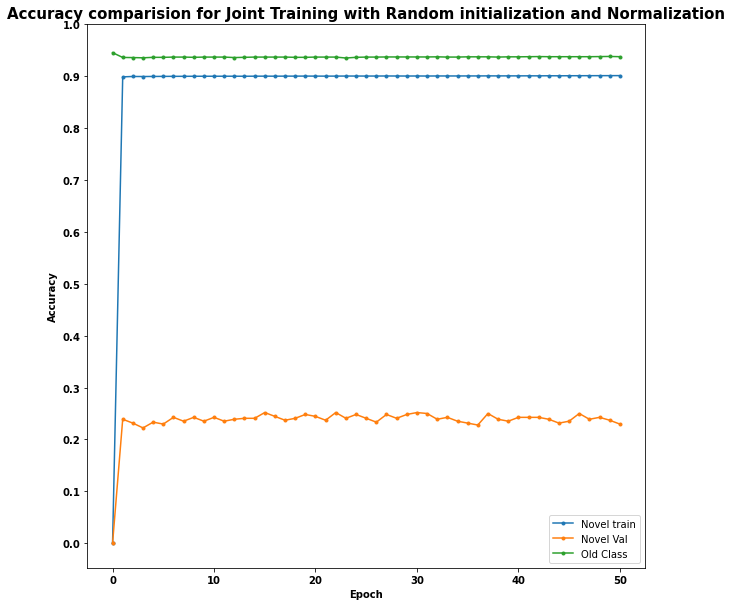

In [ ]:

plt.rcParams["figure.figsize"] = [10, 10]
# plt.rc('text', usetex=False)
fig = plt.figure(figsize = (10,10))
title_str = 'Accuracy comparision for Joint Training with ' + init_labels['random'] +  ' initialization and Normalization'
plt.plot(df_log[['train_accuracy']], label = 'Novel train', marker = '.')
plt.plot(df_log[['val_accuracy']], label = 'Novel Val', marker = '.')
plt.plot(df_log[['old_class_accuracy']], label= 'Old Class', marker = '.')
plt.legend()
plt.title('Accuracy comparision for Joint Training with ' + init_labels['random'] +  ' initialization and Normalization',fontsize=15, weight = 'bold')
# plt.figtext(0, 0.9, 'Accuracy', fontsize=20, weight = 'extra bold',  ha ='left')
# plt.figtext(0.14, 0.9, ' comparision for Joint Training w.r.t ' + init_labels['random'] +  ' initialization and Normalization',fontsize=15, weight = 'bold')
plt.yticks(np.arange(0,1.1,0.1), weight = 'bold')
plt.xticks(weight = 'bold')
plt.xlabel('Epoch', weight = 'bold')
plt.ylabel('Accuracy', weight = 'bold')

fig.savefig(title_str + ".png", format="png", dpi=600, bbox_inches="tight")
fig.savefig(title_str + ".eps", format="eps", dpi=1200, bbox_inches="tight", transparent=True)
fig.savefig(title_str + ".pdf", format="pdf", dpi=1200, bbox_inches="tight", transparent=True)

# Multitask joint training

In [27]:
learning_rate = 0.001
# T = 2
# alpha = 1
weight_decay = 1e-6
num_epochs = 10
log = []
_network = 'vgg'

# #Model 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# load model
print("Loading the pre-trained model...")
model = get_convnet("vgg")

#save old accuracy before increment
old_class_accuracy, old_class_loss = calculate_accuracy(dataloader=old_test_dataloader, model=model)
log.append({
  'epoch': -1,
  'train_loss': np.nan,
  'train_accuracy': 0,
  'val_loss': np.nan,
  'val_accuracy': 0,
  'old_class_loss' : old_class_loss,
  'old_class_accuracy': old_class_accuracy
  })

Loading the pre-trained model...
getting VGG pre-trained model


In [28]:
multiclass_learning = ["follow", "marvin", "visual", "house", "happy"]
digits = ['zero','one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine'] 
new_targets_list = digits

_temp = digits + multiclass_learning
old_traindata = SubsetSC("training", "old", dataset_length=100)

#save prev model before increment
prev_model = copy.deepcopy(model)
#freeze previous model
for param in prev_model.parameters():
  param.requires_grad = False

#increse last nodes in multiclass
# model = _incremental_model(model, is_normalize = True, _no_out_features = 15, _no_novel_class=len(multiclass_learning))
model = _incremental_model(model, init_method=init_labels['xavier_uniform'], is_normalize = True, _no_out_features = 15, _no_novel_class=len(multiclass_learning))

# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[200], gamma=0.1) #dont want scheduler here

old_traindata = SubsetSC("training", "old", dataset_length=100)
#for loop to learn novel tasks one by one and record old tasks performance during training.
for _class_name in multiclass_learning:
  print(f"Training for {_class_name}")
  traindata = SubsetSC("training", "novel", novel_class_list= [_class_name], dataset_length=50)
  testdata = SubsetSC("testing", "novel", novel_class_list= [_class_name], dataset_length=20)
  new_targets_list += [_class_name]
  def collate_fn(batch):
          tensors, targets = [], []
          for waveform, label in batch:
                  tensors += [torch.squeeze(waveform)]
                  targets += [label_to_index(_temp, label)]
          tensors = torch.unsqueeze(pad_sequence(tensors), 1)
          targets = torch.stack(targets)
          return tensors, targets
  traindata._walker += old_traindata._walker
  new_novel_train_dataloader = DataLoader(traindata,batch_size=10, collate_fn=collate_fn, shuffle=True)
  new_novel_test_dataloader = DataLoader(testdata, batch_size = 10, collate_fn=collate_fn, shuffle=True)

  train(train_dataloader= new_novel_train_dataloader, 
      test_dataloader= new_novel_test_dataloader, 
      old_test_dataloader= old_test_dataloader,
      optimizer= optimizer, 
      model= model, 
      num_epochs= num_epochs, 
      scheduler= scheduler, 
      log = log)

Initialization: Xavier_Uniform
with L2 normalization
Training for follow
Epoch [0]... train_loss: 7.690428972244263, train_acc: 0.29333333333333333
	     val_loss: 1.472421407699585, val_acc: 0.55
	     old_loss: 1.0386003255844116, old_acc: 0.7838418862690707
Epoch [1]... train_loss: 2.921527640024821, train_acc: 0.42666666666666664
	     val_loss: 1.5098457336425781, val_acc: 0.6
	     old_loss: 1.981845736503601, old_acc: 0.7957004160887656
Epoch [2]... train_loss: 3.389219705263774, train_acc: 0.38
	     val_loss: 1.391479253768921, val_acc: 0.35
	     old_loss: 0.2321021854877472, old_acc: 0.8393203883495146
Epoch [3]... train_loss: 2.8328088760375976, train_acc: 0.42
	     val_loss: 2.0455973148345947, val_acc: 0.30000000000000004
	     old_loss: 0.40404587984085083, old_acc: 0.8405339805825243
Epoch [4]... train_loss: 2.2250957171122234, train_acc: 0.42
	     val_loss: 1.2642781734466553, val_acc: 0.4
	     old_loss: 0.18015113472938538, old_acc: 0.8495145631067961
Epoch [5]... 